In [1]:
import requests as rq
import bs4
import pandas as pd
import plotly.express as px
import numpy as np

In [ ]:
gdp_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
page = rq.get(gdp_url, headers={"User-Agent": "Chrome"})
## print out the first 200 characters just to see what it looks like
page.text[0 : 99]

bs4page = bs4.BeautifulSoup(page.text, 'html.parser')
tables = bs4page.find_all('table',{'class':"wikitable"})
#print(tables[0])

from io import StringIO
# Read the table from the StringIO object into pandas
# Note most recent version of pandas won't accept a string as input, it needs to be passed through stringio
gdp_df = pd.read_html(StringIO(str(tables[0])))[0]
gdp_df = gdp_df.dropna()

gdp_df.drop([214, 215, 216, 217, 218, 219, 220, 221], inplace = True)
#gdp_df.shape

region = ["World", "Americas", "Asia", "Europe", "Asia", "Asia", "Europe", "Europe", "Europe", "Americas", "Americas", "Europe", "Americas", "Asia", "Oceania", "Europe", "Asia", "Asia", "Europe", "Asia", "Europe", "Europe", "Asia", "Europe", "Americas", "Europe", "Europe", "Europe", "Europe", "Asia", "Asia", "Asia", "Asia", "Asia", "Asia", "Asia", "Asia", "Europe", "Africa", "Africa", "Asia", "Africa", "Asia", "Americas", "Europe", "Americas", "Asia", "Europe", "Europe", "Asia", "Europe", "Americas", "Asia", "Oceania", "Europe", "Asia", "Africa", "Europe", "Europe", "Asia", "Africa", "Africa", "Europe", "Americas", "Americas", "Americas", "Americas", "Africa", "Asia", "Europe", "Americas", "Africa", "Americas", "Asia", "Europe", "Americas", "Africa", "Americas", "Asia", "Europe", "Africa", "Europe", "Asia", "Africa", "Americas", "Europe", "Asia", "Asia", "Europe", "Europe", "Africa", "Africa", "Africa", "Asia", "Africa", "Americas", "Europe", "Asia", "Americas", "Europe", "Asia", "Africa", "Asia", "Asia", "Americas", "Americas", "Africa", "Asia", "Oceania", "Africa", "Asia", "Europe", "Asia", "Africa", "Americas", "Europe", "Americas", "Africa", "Asia", "Africa", "Europe", "Africa", "Africa", "Asia", "Africa", "Africa", "Europe", "Africa", "Asia", "Africa", "Asia", "Asia", "Americas", "Americas", "Africa", "Asia", "Americas", "Europe", "Europe", "Africa", "Asia", "Asia", "Africa", "Africa", "Asia", "Africa", "Americas", "Africa", "Asia", "Africa", "Africa", "Asia", "Africa", "Europe", "Africa", "Oceania", "Africa", "Africa", "Europe", "Americas", "Europe", "Asia", "Europe", "Africa", "Americas", "Oceania", "Americas", "Oceania", "Africa", "Africa", "Africa", "Americas", "Europe", "Americas", "Africa", "Americas", "Americas", "Africa", "Africa", "Americas", "Asia", "Africa", "Americas", "Africa", "Africa", "Africa", "Africa", "Africa", "Asia", "Europe", "Africa", "Americas", "Oceania", "Americas", "Americas", "Africa", "Americas", "Oceania", "Americas", "Americas", "Americas", "Oceania", "Americas", "Africa", "Oceania", "Oceania", "Oceania", "Americas", "Oceania", "Oceania", "Oceania", "Oceania", "Americas", "Oceania"]

gdp_df["region"] = region
#gdp_df.head()

gdp_df.columns = ['Country/Territory', 'GDP', 'World Bank', 'UN', 'Region']
#gdp_df.head()

fig = px.bar(gdp_df, x = "Region", y = "GDP", color = "Country/Territory")
fig.show(renderer = "notebook")

In [93]:
url = "https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt"
multilevel_lookup = pd.read_csv(url, sep = "\t").drop(['Level5'], axis = 1)
multilevel_lookup = multilevel_lookup.rename(columns = {
    "modify"   : "roi",
    "modify.1" : "level4",
    "modify.2" : "level3",
    "modify.3" : "level2",
    "modify.4" : "level1"})
multilevel_lookup = multilevel_lookup[['roi', 'level4', 'level3', 'level2', 'level1']]
#multilevel_lookup.head()

In [96]:
## Now load in the subject data
id = 127
subjectData = pd.read_csv("https://raw.githubusercontent.com/smart-stats/ds4bio_book/main/book/assetts/kirby21AllLevels.csv")
subjectData = subjectData.loc[(subjectData.type == 1)  & (subjectData.level == 5) & (subjectData.id == id)]
subjectData = subjectData[['roi', 'volume']]
## Merge the subject data with the multilevel data
subjectData = pd.merge(subjectData, multilevel_lookup, on = "roi")
subjectData = subjectData.assign(icv = "ICV")
subjectData = subjectData.assign(comp = subjectData.volume / np.sum(subjectData.volume))
#subjectData.head(25)

In [86]:
labelsLvl1 = subjectData["level1"].unique()
labelsLvl1 = pd.Series(labelsLvl1)
labelsLvl1 = ["ICV"]+labelsLvl1.tolist()
sources_Lvl1 = [0]*(len(labelsLvl1)-1)

targets_Lvl1 = list(range(1, len(labelsLvl1)-1))

#print(labelsLvl1)
#print(sources_Lvl1)

In [84]:
flows_Lvl1 = list(range(1, len(labelsLvl1)))

for i in range(1, len(labelsLvl1)):
    temp_df = subjectData.loc[(subjectData.level1) == labelsLvl1[i]]
    flows_Lvl1[i-1] = int(temp_df["volume"].sum())
#print(flows_Lvl1)

In [83]:
labelsLvl2 = subjectData["level2"].unique()
labelsLvl2 = pd.Series(labelsLvl2)
labelsLvl2 = labelsLvl2.tolist()
#print(labelsLvl2)

targets_Lvl2 = list(range(1, len(labelsLvl2)+1))

sources_Lvl2 = list(range(1, len(labelsLvl2)))
flows_Lvl2 = list(range(1, len(labelsLvl2)))
for i in range(1, len(labelsLvl2)):
    temp_df = subjectData.loc[(subjectData.level2) == labelsLvl2[i-1]]
    flows_Lvl2[i-1] = int(temp_df["volume"].sum())
    sources_Lvl2[i-1]=temp_df["level1"].iloc[0]
#print(flows_Lvl2)
#print(sources_Lvl2)

for i in range(0, len(sources_Lvl2)):
    for u in range(1, len(labelsLvl1)):
        if sources_Lvl2[i] == labelsLvl1[u]:
                sources_Lvl2[i] = u

#print(sources_Lvl2)

In [80]:
labelsLvl3 = subjectData["level3"].unique()
labelsLvl3 = pd.Series(labelsLvl3)
labelsLvl3 = labelsLvl3.tolist()
#print(labelsLvl3)

targets_Lvl3 = list(range(1, len(labelsLvl3)+1))

sources_Lvl3 = list(range(1, len(labelsLvl3)))
flows_Lvl3 = list(range(1, len(labelsLvl3)))
for i in range(1, len(labelsLvl3)):
    temp_df = subjectData.loc[(subjectData.level3) == labelsLvl3[i-1]]
    flows_Lvl3[i-1] = int(temp_df["volume"].sum())
    sources_Lvl3[i-1]=temp_df["level2"].iloc[0]
#print(len(labelsLvl3))
#print(sources_Lvl3)

for i in range(0, len(sources_Lvl3)):
    for u in range(0, len(labelsLvl2)):
        if sources_Lvl3[i] == labelsLvl2[u]:
                sources_Lvl3[i] = u+len(sources_Lvl1)

#print(sources_Lvl3)

In [88]:
labelsLvl4 = subjectData["level4"].unique()
labelsLvl4 = pd.Series(labelsLvl4)
labelsLvl4 = labelsLvl4.tolist()
#print(labelsLvl3)

targets_Lvl4 = list(range(1, len(labelsLvl4)+1))

sources_Lvl4 = list(range(1, len(labelsLvl4)))
flows_Lvl4 = list(range(1, len(labelsLvl4)))
for i in range(1, len(labelsLvl4)):
    temp_df = subjectData.loc[(subjectData.level4) == labelsLvl4[i-1]]
    flows_Lvl4[i-1] = int(temp_df["volume"].sum())
    sources_Lvl4[i-1]=temp_df["level3"].iloc[0]
#print(len(labelsLvl3))
#print(sources_Lvl3)

for i in range(0, len(sources_Lvl4)):
    for u in range(0, len(labelsLvl3)):
        if sources_Lvl4[i] == labelsLvl3[u]:
                sources_Lvl4[i] = u+len(sources_Lvl1)+len(sources_Lvl2)

#print(sources_Lvl3)

In [90]:

sourceTotal = sources_Lvl1+sources_Lvl2+sources_Lvl3+sources_Lvl4
#print(sourceTotal)

flowsTotal = flows_Lvl1+flows_Lvl2+flows_Lvl3+flows_Lvl4
#print(flowsTotal)

targetsTotal = list(range(1, len(labelsLvl2)+len(labelsLvl1)+len(labelsLvl3)+len(labelsLvl4)))
#print(targetsTotal)

labelsTotal = labelsLvl1 + labelsLvl2 + labelsLvl3 + labelsLvl4
#print(labelsTotal)

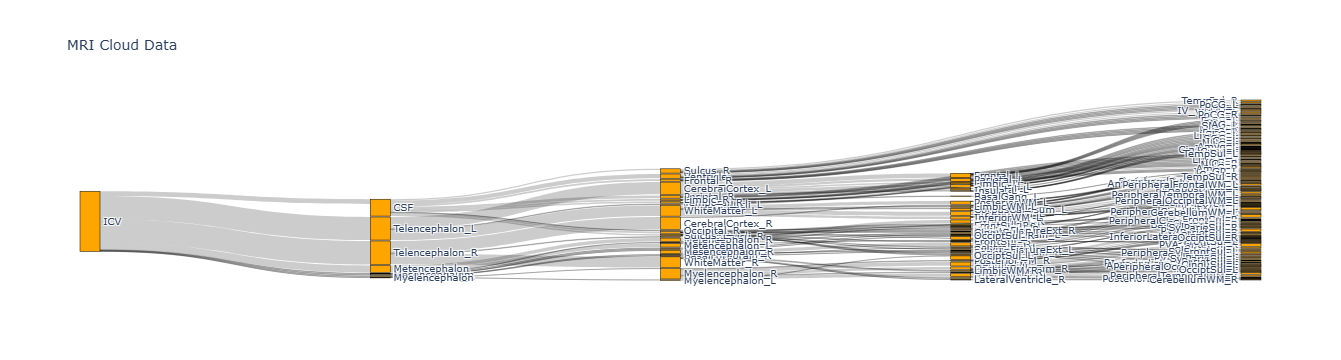

In [98]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 1,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labelsTotal,
      color = "orange"
    ),
    link = dict(
      source = sourceTotal, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = targetsTotal,
      value = flowsTotal
  ))])

fig.update_layout(title_text="MRI Cloud Data", font_size=10)
fig.show()

In [100]:
fig.write_html("hw_sankey.html")